In [1]:
import numpy as np
import cvxpy
import matplotlib.pyplot as plt
#from DrawingUtils import plot_extreme_points,graph_plane,PlotPolytope
import random as rnd
import time
# from IPython.display import clear_output

# %matplotlib notebook
# %matplotlib inline
# %config InlineBackend.close_figures=False

Note: Implementation by Vicenc

# Core functions

## Constructing linear constraints using McCormick envelopes

In [2]:
def McCormick(w,x,y,x_bounds,y_bounds):
    xL,xU = x_bounds
    yL,yU = y_bounds

    c = []
    c.append(w >= xL*y + x*yL - xL*yL)
    c.append(w >= xU*y + x*yU - xU*yU)
    c.append(w <= xU*y + x*yL - xU*yL)
    c.append(w <= x*yU + xL*y - xL*yU)
    return c

In [3]:
def one_minus_x_squared(w, x, x_bounds):
    a,b = x_bounds # lower, upper bound
    c = []
#     a_times_b = a*b
#     a_plus_b = 
#     print(x)
#     print(l1,l2,l3)
#     print(u1,u2,u3)
    c.append(w >= a*b - (a+b)*x + 1)
    c.append(w <= 1 + ((a+b)**2)/4 - (a+b)*x)
    return c

## Solving linear program

In [4]:
def bounds(x,constraints,Npast=0):

    objective_max = cvxpy.Maximize(x)
    problem_maximum = cvxpy.Problem(objective_max,constraints[-Npast:])
    value_max = problem_maximum.solve(solver=cvxpy.GUROBI)

    objective_min = cvxpy.Minimize(x)
    problem_minimum = cvxpy.Problem(objective_min,constraints[-Npast:])
    value_min = problem_minimum.solve(solver=cvxpy.GUROBI)

    return (value_min,value_max)

# Van der Pol Oscillator
(by Vicenc)

Van Der Pol Oscillator (discretized) dynamics:

$x_{t+1} = -y_t \Delta_t + x_t  $         
$y_{t+1} = -(u_t(1-x_t^2)y_t - x_t) \Delta_t + y_t$

In [5]:
def VanDerPolConstraints(T=1,variables=[],constraints=[],control_bounds=[],Npast=0, use_convex=True):
    times = []
    ss = []
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)
        xL,xU = x_bounds
        yL,yU = y_bounds
        ss.append((xU-xL)*(yU-yL))
        ######### lil plot
#         xL,xU = x_bounds
#         yL,yU = y_bounds
# #         clear_output(wait=True)
#         fig = plt.figure(1)
#         if t>0: 
#             #plt.clf()
#             plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')
#             plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'k')
#             # print("x_b: ",x_bounds)
#             # print("y_b: ",y_bounds)
#         fig.canvas.draw()   # draw
#         plt.pause(1.01)
        ########

        u = variables[t]["u"]
        u_bounds = control_bounds[t]
        constraints.append(u <= u_bounds[1])
        constraints.append(u >= u_bounds[0])
        
        if use_convex:
            v = variables[t]["v"]
            constraints.extend(one_minus_x_squared(v,x,x_bounds))
            v_bounds = bounds(v,constraints,Npast=Npast)
        else:
            n = variables[t]["n"]
            constraints.extend(McCormick(n,x,x,x_bounds,x_bounds))

            v = variables[t]["v"]
            constraints.append(v == 1 - n)
            v_bounds = bounds(v,constraints,Npast=Npast)
        

        w = variables[t]["w"]
        constraints.extend(McCormick(w,y,v,y_bounds,v_bounds))
        w_bounds = bounds(w,constraints,Npast=Npast)        

        z = variables[t]["z"]
        constraints.extend(McCormick(z,u,w,u_bounds,w_bounds)) 

        y_new = variables[t+1]["y"]
        constraints.append(y_new == -1*z*del_t + x*del_t + y)

        x_new = variables[t+1]["x"]
        constraints.append(x_new == -y*del_t + x)

        tt = time.time() - tt
        times.append(tt)
#         print("Time for ",t,"-th loop: ",tt)

    # plt.figure(2)
    # plt.plot(times,'r*')
    
#     xs,ys = forwardEulerVP(1,0,{"T":5},plot=False)
#     plt.plot(xs, ys, '*')
#     plt.show()
    
    return variables,constraints, times, ss

## Initial Setup

In [6]:
# horizon and forward Euler time step
T = 10
del_t = -0.1

# control bounds
u_min = -1.0
u_max = 1.0

# box constraints for initial state
x_up_b = 0.01 + 1
x_lw_b = -0.01 + 1
y_up_b = 0.01
y_lw_b = -0.01

$y_{t+1} = -(u_t(1-x_t^2)y_t - x_t) \Delta_t + y_t$

In [7]:
def forwardEulerVP(x0,y0,constants,plot=True):
    
    T = 3
    del_t = -0.1
    
    xs, ys = [x0], [y0]
    x,y = x0, y0
    for t in range(T):
        u = 0.8
        x, y = x-y*del_t, y - (u*(1-x**2)*y - x)*del_t
        xs.append(x)
        ys.append(y)
        
    if plot:
        plt.figure()
        plt.plot(xs, ys, '*')
    return xs, ys

## Generate plots

In [8]:
# variables = [{"u":cvxpy.Variable(),"x":cvxpy.Variable(),"y":cvxpy.Variable(),"z":cvxpy.Variable(),"w":cvxpy.Variable(),"v":cvxpy.Variable(),"n":cvxpy.Variable()} for t in range(T+1)]

# plt.figure(1)
# plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

# x = variables[0]["x"]
# y = variables[0]["y"]

# constraints = []
# constraints.append(x >= x_lw_b)
# constraints.append(x <= x_up_b)
# constraints.append(y >= y_lw_b)
# constraints.append(y <= y_up_b)

# control_bounds = [(0.2,1.0) for t in range(T)]
# #control_bounds = [(2.0,2.5),(2.0,2.5),(2.0,2.5),(2.0,2.5)]

# variables,constraints,times = VanDerPolConstraints(T,variables,constraints,control_bounds,use_convex=False)
# xL,xU = bounds(variables[-1]["x"],constraints)
# yL,yU = bounds(variables[-1]["y"],constraints)

# plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'r')
# # plt.pause(1000.0)

In [9]:
variables = [{"u":cvxpy.Variable(),"x":cvxpy.Variable(),"y":cvxpy.Variable(),"z":cvxpy.Variable(),"w":cvxpy.Variable(),"v":cvxpy.Variable(),"n":cvxpy.Variable()} for t in range(T+1)]

# plt.figure(2)
# plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

x = variables[0]["x"]
y = variables[0]["y"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)

control_bounds = [(0.2,1.0) for t in range(T)]
#control_bounds = [(2.0,2.5),(2.0,2.5),(2.0,2.5),(2.0,2.5)]

variables,constraints,times,sizes = VanDerPolConstraints(T,variables,constraints,control_bounds,use_convex=False)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)

Academic license - for non-commercial use only


In [10]:
variables = [{"u":cvxpy.Variable(),"x":cvxpy.Variable(),"y":cvxpy.Variable(),"z":cvxpy.Variable(),"w":cvxpy.Variable(),"v":cvxpy.Variable(),"n":cvxpy.Variable()} for t in range(T+1)]

# plt.figure(2)
# plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

x = variables[0]["x"]
y = variables[0]["y"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)

control_bounds = [(0.2,1.0) for t in range(T)]
#control_bounds = [(2.0,2.5),(2.0,2.5),(2.0,2.5),(2.0,2.5)]

variables,constraints,times_convex,sizes_convex = VanDerPolConstraints(T,variables,constraints,control_bounds,use_convex=True)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)

# plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'r')
# plt.pause(1000.0)

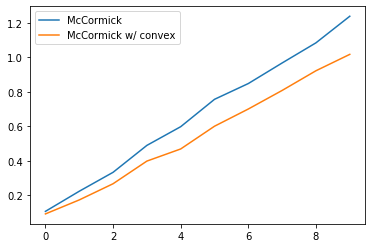

In [11]:
plt.figure()
plt.plot(list(range(T)),times,label='McCormick')
plt.plot(list(range(T)),times_convex,label='McCormick w/ convex')
plt.legend()
plt.show()

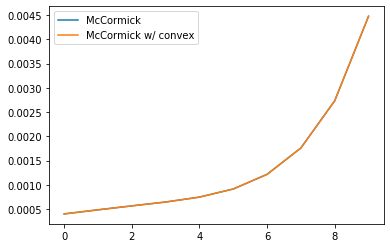

In [12]:
plt.figure()
plt.plot(list(range(T)),sizes,label='McCormick')
plt.plot(list(range(T)),sizes_convex,label='McCormick w/ convex')
plt.legend()
plt.show()